# env: pym2  on OWS

In [1]:
import os

In [2]:
import TimeTagger as TT
from TimeTagger import Flim, TimeTagStream, createTimeTaggerVirtual, EventGenerator, Countrate,ConstantFractionDiscriminator, DelayedChannel
#from intensity_renderer import IntensityRenderer
import numpy as np
from matplotlib.pyplot import *

from scipy.ndimage import maximum_filter

In [6]:
#dump_file = r"C:\Users\lociu\Desktop\PriyaM\Data\20230703_swab_tests\TimeTags_2023-07-03_125136.ttbin"
#dump_file= r'C:\Users\lociu\Desktop\PriyaM\Data\20230711_\CYCLE_000001_RAWDATA_000034.ttbin'

In [ ]:
%%time
with open(dump_file,'rb') as fid:
    d = fid.read()    
d[:100]

CPU times: total: 312 ms
Wall time: 397 ms


b'\x00\x00\x00\x00\xfc\xff\xff\xff\x0ck\xcd$\xd4\xf6;\x00\x00\x00\x00\x00\xf5\x03\x00\x00\xe3m\xcd$\xd4\xf6;\x00\x00\x00\x00\x00\x04\x00\x00\x00\xb9p\xcd$\xd4\xf6;\x00\x00\x00\x00\x00\x03\x00\x00\x00\xd2\x85\xcd$\xd4\xf6;\x00\x00\x00\x00\x00\xfb\xff\xff\xff\x04\x0e\x124\xd4\xf6;\x00\x00\x00\x00\x00\x03\x00\x00\x00\x10\x11\x124\xd4\xf6;\x00\x00\x00\x00\x00'

In [4]:
import glob

In [5]:
for filename in glob.glob(r'C:\Users\lociuser\Documents\UserData\HelenWilson\20230712_flim\*.ttbin'):
    fr = TT.FileReader(filename)
    print(fr.getConfiguration())
    break

{'channel number scheme': 2, 'configure version': 1, 'current time': '2023-07-12 11:24:28 -0500', 'devices': [{'PCB version': '1.6b (1)', 'model': 'Time Tagger Ultra', 'serial': '2143000XZI'}], 'firmware version': 'TT-Ultra, FW 5, TS 2022-02-02 13:09:16, OK 1.31', 'fpga link': {'enabled': False}, 'hardware buffer size': 67108864, 'inputs': [{'channel': [1, -1], 'conditional filter filtered': [True, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [552, 552], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 8.0, 'trigger level': -0.05}, {'channel': [2, -2], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'har

In [8]:
from TimeTagger import Flim, TimeTagStream, createTimeTaggerVirtual, EventGenerator, Countrate,ConstantFractionDiscriminator, DelayedChannel

In [9]:
dump_file = filename

# flim

In [13]:
laser = 1
click = laser
frame = 3 
frame_n = -3
line = 2
line_n = -2
photon = -4

n_bins = 256
binwidth = 48 # 12.5ns/256
n_pixel = 256

laser_frequency = 80e6  # 1/12.5ns

pixel_rate = 200e3
pixel_time = 1 / pixel_rate
integr_time = 3e9 # Integration time of 3 ms in picoseconds

In [17]:
#3e9,(pixel_time*256*256)

In [18]:
time_tag_virt=TT.createTimeTaggerVirtual()

In [19]:
pixel_pattern_start = np.linspace(0, 256, num=n_pixel, endpoint=False, dtype=int) * (pixel_time * 1e12)

In [20]:
pixel_pattern_end = pixel_pattern_start + integr_time

In [22]:
#pixel_pattern_start, pixel_pattern_end

# check pixel channels

In [23]:
# EventGenerator(tagger, trigger_channel, pattern, trigger_divider, stop_channel)
pixel_start_channel = EventGenerator(time_tag_virt, line, pixel_pattern_start)
pixel_end_channel= EventGenerator(time_tag_virt, line, pixel_pattern_end)

In [24]:
pixel_start = pixel_start_channel.getChannel()
pixel_end = pixel_end_channel.getChannel()

In [25]:
# Countrate(tagger, channels)
rate = Countrate(time_tag_virt, [frame, line, pixel_start])

In [26]:
all_rates = Countrate(time_tag_virt, [1, 2, 3, 4, -1, -2, -3, -4])

In [27]:
intervals = TT.StartStop(time_tag_virt, -line, line, 0.1e-3/1e-12)

In [28]:
%%time
time_tag_virt.setReplaySpeed(-1)
replay = time_tag_virt.replay(dump_file)
time_tag_virt.waitForCompletion()

CPU times: total: 594 ms
Wall time: 725 ms


True

In [29]:
#check that pixel clock is correct
# Run Countrate for 1 second and print the result for all three channels
#rate.startFor(int(1e12), clear=True)
#rate.waitUntilFinished()
comp_data = rate.getData()
comp_data

array([1.11111111e+00, 2.89622222e+02, 7.41432889e+04])

In [30]:
print("lines/frame = ", comp_data[1]/comp_data[0])
print("pixels/line = ", comp_data[2]/comp_data[1])

lines/frame =  260.65999999999997
pixels/line =  256.0


In [31]:
all_rates.getData()

array([1.35305711e+05, 2.89622222e+02, 1.11111111e+00, 1.35403356e+05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.35405178e+05])

In [32]:
fi = intervals.getData()
fi

array([], shape=(0, 2), dtype=int64)

# flim class

In [33]:
time_tag_virt=TT.createTimeTaggerVirtual()
time_tag_virt.reset()

In [34]:
# EventGenerator(tagger, trigger_channel, pattern, trigger_divider, stop_channel)
pixel_start_channel = EventGenerator(time_tag_virt, line, pixel_pattern_start)
pixel_start = pixel_start_channel.getChannel()

pixel_end_channel= EventGenerator(time_tag_virt, line, pixel_pattern_end)
pixel_end = pixel_end_channel.getChannel()

In [35]:
#ConstantFractionDiscriminator(tagger, channels, search_window)
photon_cfd_chan = ConstantFractionDiscriminator(time_tag_virt, (photon,), 10*1000)
photon_cfd = photon_cfd_chan.getChannels()[0]

In [36]:
#DelayedChannel(tagger, input_channel, delay)
delayed_sync_chan = DelayedChannel(time_tag_virt, laser, 11.5e3)
delayed_sync = delayed_sync_chan.getChannel()

In [37]:
flim = Flim(time_tag_virt, start_channel=delayed_sync, click_channel=photon_cfd, pixel_begin_channel=pixel_start, n_pixels=n_pixel*n_pixel,
             n_bins=n_bins, binwidth=binwidth, pixel_end_channel=pixel_end, frame_begin_channel=frame)

In [38]:
%%time
time_tag_virt.setReplaySpeed(-1)
replay = time_tag_virt.replay(dump_file)
time_tag_virt.waitForCompletion()

CPU times: total: 2.02 s
Wall time: 3.33 s


True

In [39]:
#flim.waitUntilFinished()
flim.getFramesAcquired()

49

In [41]:
flim_frames = flim.getSummedFrames()

In [42]:
flim_frames.shape

(65536, 256)

In [43]:
flim_2d = flim_frames.reshape(256,256,256)

In [44]:
flim_mean = flim_2d.mean(2)
flim_mean.shape

(256, 256)

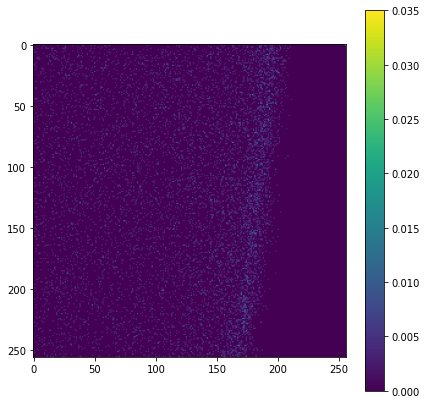

In [50]:
#rcParams['figure.figsize'] = [10,10]
figure(figsize=[7,7])
imshow(flim_mean,vmax=.035)
colorbar()

In [51]:
plot(flim_2d.sum((0,1)))

TypeError: 'list' object is not callable

In [40]:
maximas = (flim_mean == maximum_filter(flim_mean, footprint=np.ones((50,50))))

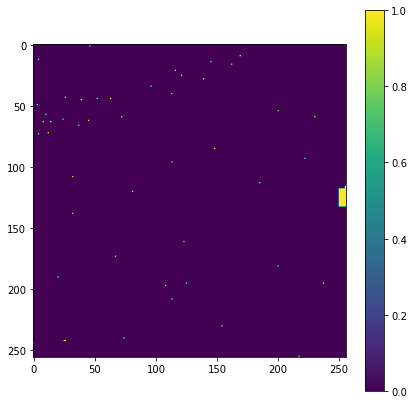

In [26]:
figure(figsize=[7,7])
imshow(maximas)
colorbar()

In [20]:
#check how many for percent
dec = .005
perc = 100- (dec*100)
flim_mean.size *dec

327.68

In [21]:
maxima2 = (flim_mean==np.percentile(flim_mean.ravel(), perc))

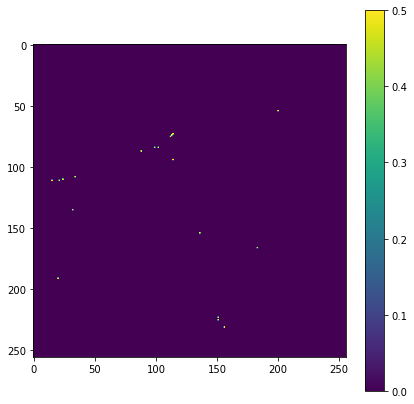

In [22]:
figure(figsize=[7,7])
imshow(maxima2,vmax=.5)
colorbar()